In [1]:
from scipy import stats
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

/anaconda3/envs/py37/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [21]:
train = pd.read_pickle('../src/make_data/data/030_train.pkl')
test = pd.read_pickle('../src/make_data/data/030_test.pkl')

In [22]:
test_split = 5
test_index = np.array_split(test.index,test_split)

In [23]:
test = test.loc[test_index[0]]

In [24]:
train = train.drop(['isFraud','TransactionDT','month'],axis=1)
test = test.drop(['TransactionDT','month'],axis=1)

In [25]:
print(train.shape,test.shape)

(590540, 643) (101339, 643)


In [26]:
for f in tqdm(train.select_dtypes(include='category').columns.tolist() + train.select_dtypes(include='object').columns.tolist()):
    lbl = LabelEncoder()
    lbl.fit(list(train[f].values) + list(test[f].values))
    train[f] = lbl.transform(list(train[f].values))
    test[f] = lbl.transform(list(test[f].values))

100%|██████████| 41/41 [00:45<00:00,  1.73it/s]


In [27]:
train['target'] = 0
test['target'] = 1

In [28]:
train_test = pd.concat([train, test], axis =0)
target = train_test['target'].values

In [29]:
x = train_test.drop('target',axis=1)
# y = train_test.drop('target',axis=1)

In [30]:
x_train, x_test, y_train,y_test = train_test_split(x,target,test_size=0.33, random_state=42, shuffle=True)

In [31]:
# X_train = X_train.drop('card2',axis=1)
# X_test = X_test.drop('card2',axis=1)

In [32]:
train_lgb = lgb.Dataset(x_train, label=y_train)
test_lgb = lgb.Dataset(x_test, label=y_test)

In [33]:
param = {'num_leaves': 50,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 5,
         'learning_rate': 0.2,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 44,
         "metric": 'auc',
         "verbosity": -1}

In [34]:
test.shape

(101339, 644)

In [35]:
num_round = 100
clf = lgb.train(
    param,
    train_lgb,
    num_round,
    valid_sets=[train_lgb, test_lgb],
    verbose_eval=50,
    early_stopping_rounds = 50
)

Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1


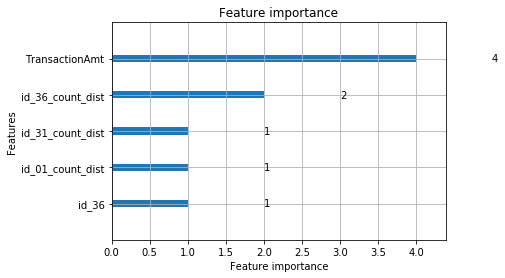

In [36]:
lgb.plot_importance(clf,max_num_features=5)

In [ ]:
while True:
    trn_data = lgb.Dataset(x_train, label=y_train)
    val_data = lgb.Dataset(x_test, label=y_test)

    num_round = 100
    lgb_model = lgb.train(
                param,
                trn_data,
                num_round,
                valid_sets=[trn_data, val_data],
                verbose_eval=50,
                early_stopping_rounds = 50
                )

    pred = lgb_model.predict(x_test)
    auc = roc_auc_score(y_test, pred)
    print(auc)
    if auc < 0.75:
        break
    
    importance = pd.DataFrame(lgb_model.feature_importance(), index=x_train.columns, columns=['importance']).sort_values(by='importance',ascending=False)
    list_drop = list(importance.index[:15])
    x_train = x_train.drop(list_drop,axis=1)
    x_test = x_test.drop(list_drop,axis=1)
    print(list_drop)

Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
1.0
['TransactionAmt', 'id_36_count_dist', 'id_02', 'id_36', 'id_31_count_dist', 'id_01_count_dist', 'card2', 'id_19', 'id_33', 'id_35', 'id_16', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
1.0
['card1', 'id_33_count_dist', 'id_35_count_dist', 'ProductCD', 'card3', 'id_31_e_6.4', 'id_26', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_34', 'dow', 'hour']
Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.998075	valid_1's auc: 0.997966
[100]	training's auc: 0.99984	valid_1's auc: 0.999808
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.99984	valid_1's auc: 0.999808
0.9998078701760

In [ ]:
x_train, x_test, y_train,y_test = train_test_split(x,target,test_size=0.33, random_state=42, shuffle=True)
x_train = x_train.drop(['month'],axis=1)
x_test = x_test.drop(['month'],axis=1)

In [ ]:
sh_train_test = train_test.sample(frac=1)
x = sh_train_test.drop('target',axis=1)
target = sh_train_test['target'].values

In [30]:
# while True:
kfold_splits = 5
folds = KFold(n_splits=kfold_splits,shuffle=True)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(x.values, target)):
    print(val_idx)
#     train_df, y_train_df = X_train.iloc[trn_idx], target.iloc[trn_idx]
#     valid_df, y_valid_df = X_train.iloc[val_idx], target.iloc[val_idx]

#     trn_data = lgb.Dataset(train_df, label=y_train_df)
#     val_data = lgb.Dataset(valid_df, label=y_valid_df)

#     num_round = 100
#     lgb_model = lgb.train(
#                 param,
#                 trn_data,
#                 num_round,
#                 valid_sets=[trn_data, val_data],
#                 verbose_eval=50,
#                 early_stopping_rounds = 50
#                 )

#     pred = lgb_model.predict(valid_df)
#     auc = roc_auc_score(y_test, pred)
    print(auc)
#         if auc < 0.75:
#             break

[      5       8      20 ... 1097221 1097223 1097228]
0.7469515107639056
[      3      10      15 ... 1097224 1097227 1097229]
0.7469515107639056
[      4       6      11 ... 1097225 1097226 1097230]
0.7469515107639056
[      0      27      31 ... 1097199 1097205 1097219]
0.7469515107639056
[      1       2       7 ... 1097216 1097217 1097222]
0.7469515107639056


In [28]:
folds.split(x.values, target)

<generator object _BaseKFold.split at 0x1a5a1637c8>